In [1]:
# libs basicas data science
from sklearn import datasets
import numpy as np
import pandas as pd
from scipy import stats
import math

#libs visualizacao
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML
from mlxtend.plotting import plot_decision_regions

#sklean model selection http://scikit-learn.org/
from sklearn.model_selection import cross_val_score, train_test_split

#sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# mlxtend classifiers https://rasbt.github.io/mlxtend/
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
sns.set(style="ticks")

# Iris Dataset

In [3]:
iris = datasets.load_iris()

In [4]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris.target_names[iris.target]], 
                       columns= iris['feature_names'] + ['class'])
for col in iris['feature_names']:
    iris_df[col] = pd.to_numeric(iris_df[col])

In [5]:
iris_df.shape

(150, 5)

In [6]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [8]:
iris_df.groupby('class').size()

class
setosa        50
versicolor    50
virginica     50
dtype: int64

C:\Users\Felli\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


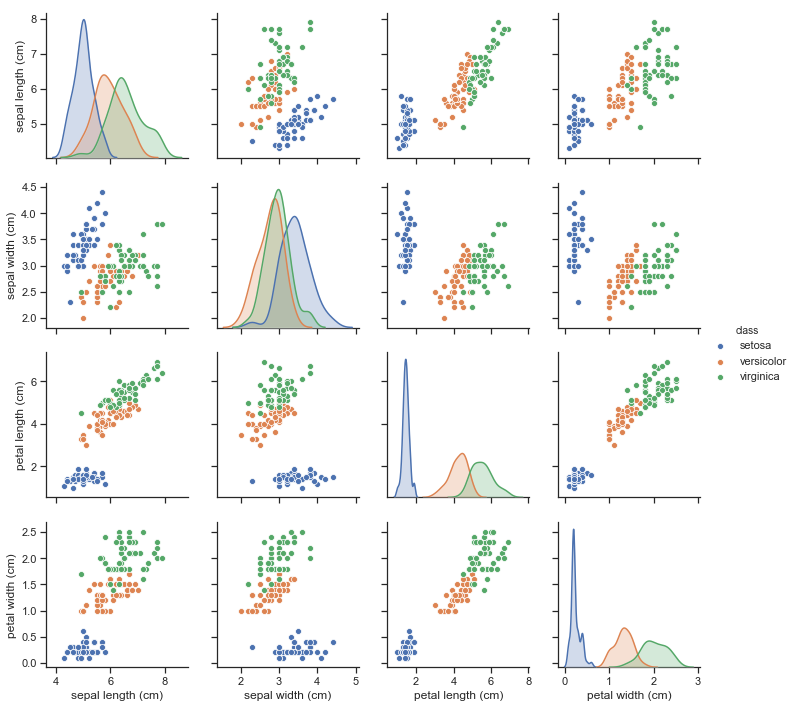

In [9]:
sns.pairplot(iris_df, hue="class", diag_kind="kde")
plt.show()

# Métodos utilitários

In [10]:
def get_predictions(models, X, y):
    validation_size = 0.20
    seed = 13
    X_train, X_validation, y_train, y_validation = \
        train_test_split(X, y, test_size=validation_size, random_state=seed)    
    predictions = [y_validation]
    labels = []
    for name in models.keys():
        model = models[name]
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_validation))
        labels.append(name)
    predictions_df = pd.DataFrame(data=np.transpose(predictions), columns=(['Y'] + list(models.keys()))) 
    return predictions_df

In [11]:
def models_correlation(predictions_df):
    corr = predictions_df.iloc[:, 1:].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu")
    plt.show()

In [12]:
def highlight_error(s):
    is_error = s != s.iloc[0]
    return ['color: red' if v else 'color: black' for v in is_error]

In [13]:
def print_predictions(models, X, y):
    predictions_df = get_predictions(models, X, y)
    return predictions_df.style.apply(highlight_error, axis=1)

In [14]:
def train_and_report(models, X, y):
    results = []
    for name in models.keys():
        model = models[name]
        scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
        print("Accuracy: %.3f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), name))

In [15]:
def plot_decision_boundaries(models, X, y, cols=3):
        
    fig = plt.figure()
    rows = math.ceil(len(models) / (cols * 1.0))
    gs = gridspec.GridSpec(rows, cols)
    grid = []
    for r in range(rows):
        for c in range(cols):
            grid.append((r,c))

    clf_list = models.values()
    labels = models.keys()
    
    for clf, label, grd in zip(clf_list, labels, grid):
        
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(label)

    plt.show()

# Treinamento dos modelos isoladamente

In [16]:
X, y = iris.data[:, 0:2], iris.target

In [17]:
models = {}
models['LR'] = LogisticRegression()
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier(random_state=13)
models['NB'] = GaussianNB()
models['SVC'] = SVC(probability=True)

In [18]:
train_and_report(models, X, y)

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.807 (+/- 0.087) [LDA]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.667 (+/- 0.094) [CART]
Accuracy: 0.793 (+/- 0.087) [NB]
Accuracy: 0.813 (+/- 0.078) [SVC]


C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

# Votação

## Maioria

In [19]:
#voting_models_names = models.keys()
voting_models_names = ['LR', 'KNN', 'SVC']
voting_models = {name: models[name] for name in voting_models_names}
voting_estimators = [(name, models[name]) for name in voting_models_names]

In [20]:
print_predictions(voting_models, X, y)

C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Y,LR,KNN,SVC
0,1,1,1,1
1,1,1,1,1
2,0,0,0,0
3,2,1,1,1
4,2,2,1,2
5,0,0,0,0
6,2,2,2,2
7,2,1,2,1
8,0,0,0,0
9,1,1,1,1


In [21]:
voting_models['MAJORITY'] = VotingClassifier(estimators=voting_estimators, voting='hard')

In [22]:
train_and_report(voting_models, X, y)

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.813 (+/- 0.078) [SVC]
Accuracy: 0.787 (+/- 0.078) [MAJORITY]


C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

In [23]:
print_predictions(voting_models, X, y)

C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packag

,Y,LR,KNN,SVC,MAJORITY
0,1,1,1,1,1
1,1,1,1,1,1
2,0,0,0,0,0
3,2,1,1,1,1
4,2,2,1,2,2
5,0,0,0,0,0
6,2,2,2,2,2
7,2,1,2,1,1
8,0,0,0,0,0
9,1,1,1,1,1


C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packag

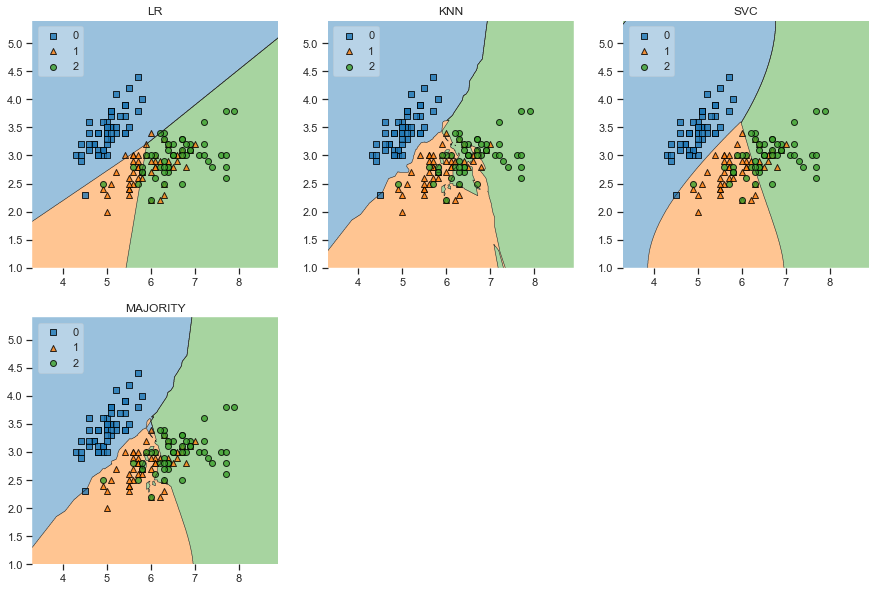

In [24]:
plot_decision_boundaries(voting_models, X, y)

## Ponderado

In [25]:
voting_models['WEIGHT_AVG'] = VotingClassifier(estimators=voting_estimators, 
                                               weights=[0.7, 0.7, 1.0],
                                               voting='soft')

In [26]:
train_and_report(voting_models, X, y)

C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.813 (+/- 0.078) [SVC]
Accuracy: 0.787 (+/- 0.078) [MAJORITY]
Accuracy: 0.820 (+/- 0.085) [WEIGHT_AVG]


C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packag

## Correlação entre os modelos

C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


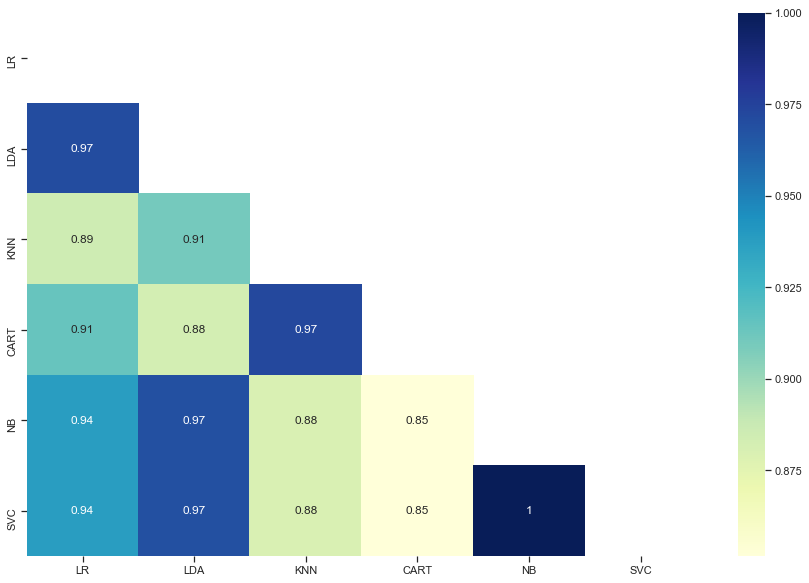

In [27]:
predictions = get_predictions(models, X, y)
models_correlation(predictions)

# Stacking

In [28]:
Image(url= "https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png")

In [29]:
#stacking_models_names = models.keys()
stacking_models_names = ['LR', 'KNN', 'SVC']
stacking_models = {name: models[name] for name in stacking_models_names}
stacking_models['RF'] = RandomForestClassifier(random_state=13)
stacking_estimators = [models[name] for name in stacking_models_names]
stacking_estimators.append(stacking_models['RF'])

In [30]:
stacking = StackingClassifier(classifiers=stacking_estimators,
                              use_probas=True,
                              average_probas=True,
                              meta_classifier=models['LR'])

In [31]:
stacking_models['STACKING'] = stacking

In [35]:
train_and_report(stacking_models, X, y)

C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

Accuracy: 0.760 (+/- 0.074) [LR]
Accuracy: 0.747 (+/- 0.083) [KNN]
Accuracy: 0.813 (+/- 0.078) [SVC]
Accuracy: 0.713 (+/- 0.103) [RF]
Accuracy: 0.767 (+/- 0.080) [STACKING]


C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packag

C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Felli\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Felli\

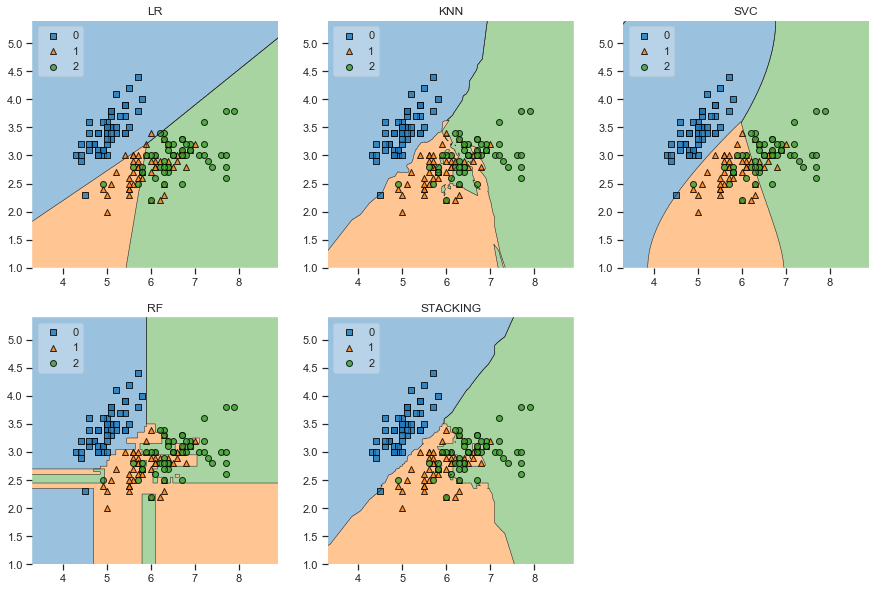

In [33]:
plot_decision_boundaries(stacking_models, X, y)

# Referencias

- https://github.com/gilmar/udacity-live-coding-ensembles-stacking

- https://mlwave.com/kaggle-ensembling-guide/
- https://blog.statsbot.co/ensemble-learning-d1dcd548e936
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
- https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
- http://scikit-learn.org/stable/modules/ensemble.html
- http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/